In [1]:
# pip install matplotlib
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import pyspark.sql.functions as F
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dotenv import load_dotenv
load_dotenv()

print(_find_spark_home())

C:\Users\yan4etooo\anaconda3\envs\bigdata\Lib\site-packages\pyspark


In [2]:
python_path = os.environ.get('PYTHON_PATH')
app_name_nov = os.environ.get('APP_NAME_NOV')
hadoop_path_nov = os.environ.get('HADOOP_NOV_DATASET_PATH')

In [3]:
conf = SparkConf()\
    .setMaster('local[*]')\
    .set('spark-local-dir', "C:\\spark-temp")\
    .set('spark.driver.memory', '4g')\
    .set('spark.executor.memory', '4g')\
    .set('spark.driver.maxResultSize', '2g')\
    .set('spark.pyspark.python', python_path)\
    .set('spark.pyspark.driver.python', python_path)\
    .set("spark.network.timeout","800s")\
    .set("spark.dynamicAllocation.enabled", "true")\
    .set("spark.shuffle.service.enabled", "true")\
    .set("spark.dynamicAllocation.minExecutors", "1")\
    .set("spark.dynamicAllocation.maxExecutors", "10")\
    .set("spark.dynamicAllocation.executorIdleTimeout", "60s")\

spark = SparkSession.builder.appName(app_name_nov).config(conf=conf).getOrCreate()
sc = spark.sparkContext

for item in sc.getConf().getAll(): print(item)

('spark.dynamicAllocation.minExecutors', '1')
('spark.shuffle.service.enabled', 'true')
('spark.driver.host', '194.47.28.39')
('spark.driver.memory', '4g')
('spark.app.name', 'eCommerce')
('spark.executor.memory', '4g')
('spark.dynamicAllocation.maxExecutors', '10')
('spark.executor.id', 'driver')
('spark.driver.port', '64527')
('spark.app.submitTime', '1703763021842')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAM

In [4]:
df = spark.read.csv(hadoop_path_nov+'/selected_Data/', header = True, inferSchema = True)
df.show()

+------------+----------+----------+----------+-------+---------+-----------+--------------------+---+
|          id|event_type|product_id|     brand|  price|  user_id|   category|             product|day|
+------------+----------+----------+----------+-------+---------+-----------+--------------------+---+
|403727064801|      view|   1004239|     apple|1413.16|554666475|electronics|          smartphone| 18|
| 42950433984|      view|   1004250|     apple| 741.04|527029321|electronics|          smartphone|  4|
| 34360364567|      view|   1004886|      oppo| 128.67|543083998|electronics|          smartphone|  4|
|360777911454|      view|   1480156|       neo| 666.66|519293476|  computers|             desktop| 17|
| 85900085278|      view|   6400162|     intel| 215.58|533512255|  computers|      components.cpu|  7|
|180389410990|      view|   1201284|    lenovo| 154.19|570911983|electronics|              tablet| 13|
| 17180281985|      view|   3900339|      aqua|  30.86|517565940| applian

### Question:
How many times did the customer view the product before purchasing it?

In [5]:
# Apply filter early and select only necessary columns
views_df = df.filter(df.event_type == 'view').select('user_id', 'product_id', 'day').withColumnRenamed('day', 'day_view')
purchases_df = df.filter(df.event_type == 'purchase').select('user_id', 'product_id', 'day', 'product', 'category', 'brand', 'price').withColumnRenamed('day', 'day_purchase')

# Join on user_id and product_id (using regular join here)
joined_df = views_df.join(purchases_df, ['user_id', 'product_id'], 'inner')

# Cache joined_df if it will be used multiple times
# joined_df.cache()

# Ensure views are before purchase and filter
valid_views_df = joined_df.filter(joined_df.day_view <= joined_df.day_purchase)

# Group and aggregate
final_df = valid_views_df.groupBy('user_id', 'product_id', 'product', 'category', 'brand', 'price') \
                         .agg(F.count('day_view').alias('views_before_purchase'))

# Show the final DataFrame
final_df.show()

+---------+----------+--------------------+-----------+--------+------+---------------------+
|  user_id|product_id|             product|   category|   brand| price|views_before_purchase|
+---------+----------+--------------------+-----------+--------+------+---------------------+
|307138432|   1004904|          smartphone|electronics|  huawei|106.57|                    1|
|315835135|  17800444|             desktop|  computers| dxracer|334.37|                    4|
|369801696|   1005115|          smartphone|electronics|   apple|914.43|                    1|
|404851685|   5800605|     audio.subwoofer|electronics|   focal|  48.5|                    2|
|439209037|   7003777|            carriage|       kids|    anex|790.24|                    7|
|442687924|   1005099|          smartphone|electronics| samsung|136.66|                    1|
|445339240|   6701017|components.videoc...|  computers|gigabyte|277.74|                    3|
|456056600|   1005121|          smartphone|electronics|   ap

In [8]:
# Order final_df by views_before_purchase in descending order
sorted_final_df = final_df.orderBy(F.desc('views_before_purchase'))

# Show the sorted DataFrame
sorted_final_df.show()

+---------+----------+--------------------+-----------+-------+-------+---------------------+
|  user_id|product_id|             product|   category|  brand|  price|views_before_purchase|
+---------+----------+--------------------+-----------+-------+-------+---------------------+
|518514099|   1005116|          smartphone|electronics|  apple|1013.85|                13031|
|549385752|   4804056|     audio.headphone|electronics|  apple| 167.06|                11415|
|566195962|   1801723|            video.tv|electronics|    tcl| 149.29|                 9545|
|543128872|   4804056|     audio.headphone|electronics|  apple| 161.63|                 8004|
|564068124|   1004833|          smartphone|electronics|samsung| 170.05|                 5229|
|541385001|   1005113|          smartphone|electronics|  apple|1052.28|                 4808|
|543128872|   4804056|     audio.headphone|electronics|  apple|  162.6|                 4012|
|543128872|   4804056|     audio.headphone|electronics|  app

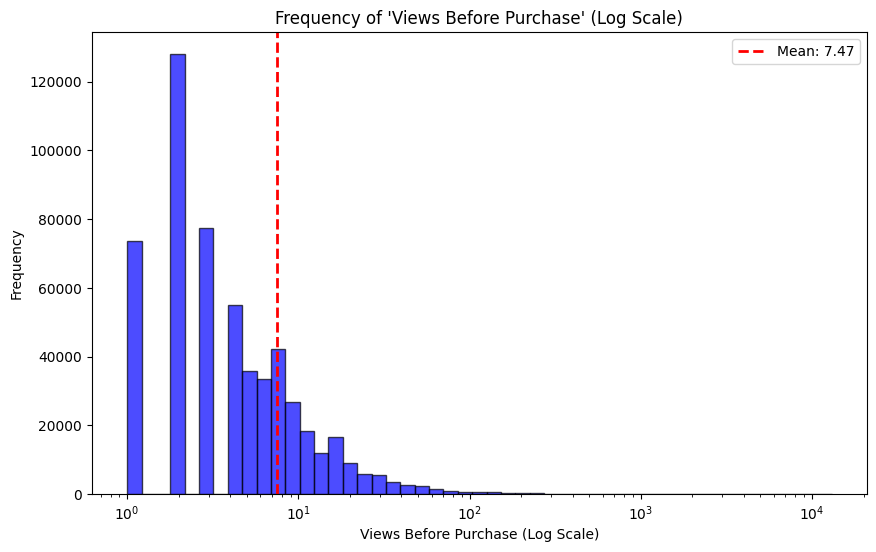

In [ ]:
# Convert the specific column to Pandas for visualization
views_before_purchase_pd = final_df.select('views_before_purchase').toPandas()

# Create a histogram for the views
plt.figure(figsize=(10, 6))
plt.hist(views_before_purchase_pd['views_before_purchase'], bins=np.logspace(np.log10(1), np.log10(views_before_purchase_pd['views_before_purchase'].max()), 50), alpha=0.7, color='blue', edgecolor='black')
plt.gca().set_xscale("log")

# Calculate and show mean
mean_value = views_before_purchase_pd['views_before_purchase'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

title = "Frequency of 'Views Before Purchase' (Log Scale)"
plt.title(title)
plt.xlabel('Views Before Purchase (Log Scale)')
plt.ylabel('Frequency')
plt.legend()

plt.show()


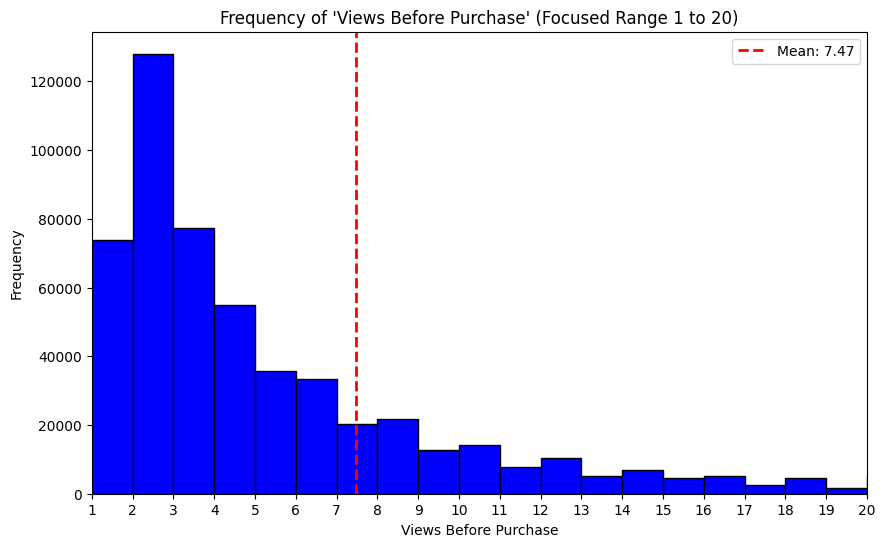

In [ ]:
# Assuming views_before_purchase_pd is a Pandas DataFrame with the 'views_before_purchase' column

# Determine the upper bound for the histogram
upper_bound = views_before_purchase_pd['views_before_purchase'].quantile(0.95)

# Plot the histogram focusing on the most common values
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(views_before_purchase_pd['views_before_purchase'], 
                                 bins=range(1, int(upper_bound) + 1), 
                                 edgecolor='black', 
                                 color='blue')

# Set the x-axis limit to include only 1 to 20
plt.xlim(1, 20)

# Calculate and show mean
mean_value = views_before_purchase_pd['views_before_purchase'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

# Set the x-axis ticks to show every number from 1 to 20
plt.xticks(range(1, 21))

# Title and labels
plt.title("Frequency of 'Views Before Purchase' (Focused Range 1 to 20)")
plt.xlabel('Views Before Purchase')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()


In [ ]:
print("Top 5 Most Frequent 'Views Before Purchase':")

# Calculate the top 5 most frequent 'views_before_purchase' values along with their frequencies
top5_freq = views_before_purchase_pd['views_before_purchase'].value_counts().nlargest(5)

# Creating a DataFrame for a better presentation
top5_table = pd.DataFrame({
    'Views Before Purchase': top5_freq.index,
    'Frequency': top5_freq.values
})

# Display the table
print(top5_table)

Top 5 Most Frequent 'Views Before Purchase' Values and Their Frequencies:
   Views Before Purchase  Frequency
0                      2     128037
1                      3      77416
2                      1      73696
3                      4      54967
4                      5      35834


C:\Users\yan4etooo\AppData\Local\Temp\ipykernel_6716\1135265294.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_views_per_category = final_pd.groupby('price_category')['views_before_purchase'].mean()


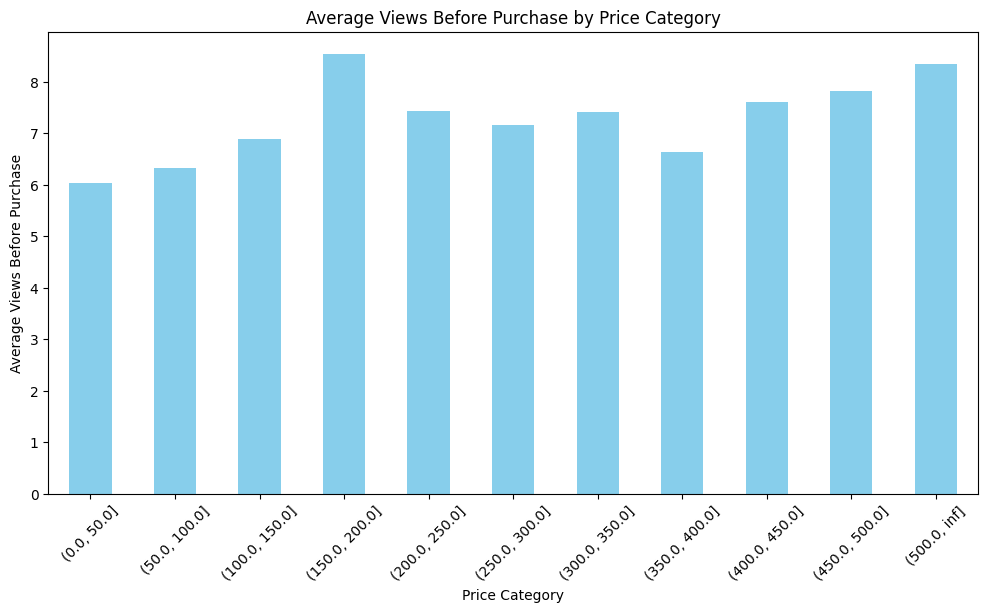

In [15]:
# Assuming final_df is your Spark DataFrame with necessary columns
# Convert the DataFrame to Pandas for visualization
final_pd = final_df.toPandas()

# Define price bins - adjust these based on your data's price range
price_bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, np.inf]
final_pd['price_category'] = pd.cut(final_pd['price'], bins=price_bins)

# Calculate average views per price category
avg_views_per_category = final_pd.groupby('price_category')['views_before_purchase'].mean()

# Create a bar chart
plt.figure(figsize=(12, 6))
avg_views_per_category.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.title('Average Views Before Purchase by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Average Views Before Purchase')

# Show the plot
plt.xticks(rotation=45)
plt.show()


#### Question 2
Which were the most purchased and viewed products?

In [16]:
# Group by product_id, brand, and product, and pivot on event_type to get counts of views and purchases
product_event_counts = df.groupBy("product_id", "brand", "product") \
                             .pivot("event_type") \
                             .count()

# Replace null values with 0 in view and purchase columns for accurate counting
product_event_counts = product_event_counts.na.fill(value=0, subset=["view", "purchase"])

In [17]:
most_viewed = product_event_counts.orderBy(F.desc("view")).select("product", "view")

print("Most Viewed Products:")
most_viewed.show()

Most Viewed Products:
+---------------+------+
|        product|  view|
+---------------+------+
|     smartphone|583010|
|     smartphone|522880|
|     smartphone|482898|
|audio.headphone|318339|
|     smartphone|304614|
|     smartphone|275721|
|     smartphone|272097|
|     smartphone|254931|
|     smartphone|247446|
|     smartphone|229920|
|     smartphone|216374|
|     smartphone|198101|
|     smartphone|193835|
|     smartphone|179932|
|     smartphone|166202|
|     smartphone|158024|
|     smartphone|149872|
|audio.headphone|147488|
|     smartphone|139003|
|     smartphone|136844|
+---------------+------+
only showing top 20 rows



In [18]:
most_purchased = product_event_counts.orderBy(F.desc("purchase")).select("product", "purchase")

print("Most Purchased Products:")
most_purchased.show()

Most Purchased Products:
+---------------+--------+
|        product|purchase|
+---------------+--------+
|     smartphone|   32321|
|     smartphone|   22613|
|     smartphone|   22244|
|audio.headphone|   17800|
|     smartphone|   13486|
|     smartphone|   11678|
|     smartphone|   10673|
|     smartphone|   10132|
|     smartphone|    8881|
|     smartphone|    8483|
|     smartphone|    7858|
|     smartphone|    6877|
|     smartphone|    6244|
|     smartphone|    6153|
|     smartphone|    5174|
|     smartphone|    5067|
|     smartphone|    4622|
|     smartphone|    4284|
|     smartphone|    4276|
|audio.headphone|    3776|
+---------------+--------+
only showing top 20 rows



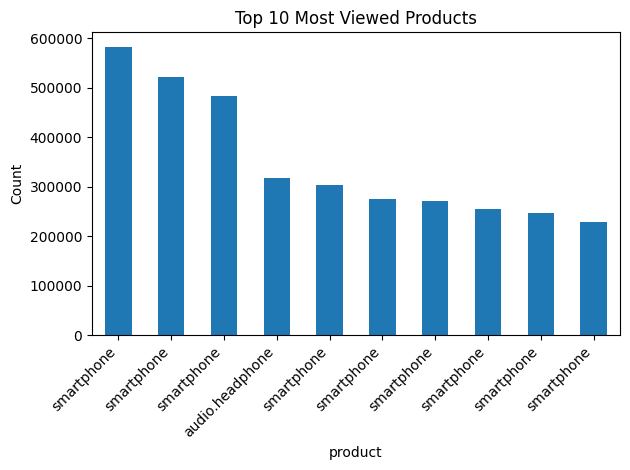

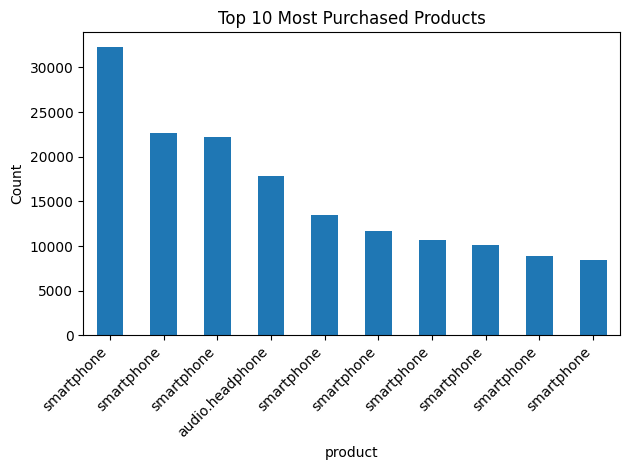

In [19]:
# Convert to Pandas DataFrame for easier plotting
most_viewed_pd = most_viewed.limit(10).toPandas()
most_purchased_pd = most_purchased.limit(10).toPandas()

# Define a function for plotting
def plot_top_products(df, title, y_label):
    df.plot(kind='bar', x='product', y=y_label, legend=None)
    plt.title(title)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  # Rotate product names for better readability
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()

# Plotting the most viewed products
plot_top_products(most_viewed_pd, 'Top 10 Most Viewed Products', 'view')

# Plotting the most purchased products
plot_top_products(most_purchased_pd, 'Top 10 Most Purchased Products', 'purchase')

spark.stop()